<a href="https://colab.research.google.com/github/purvikabajaj/Convolutional-Neural-Networks/blob/master/Transfer_Learning_Horses_vs_Humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-09-04 08:04:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  80.5MB/s    in 1.8s    

2020-09-04 08:04:47 (80.5 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-09-04 08:04:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  7.42MB/s    in 1.5s    

2020-09-04 08:04:51 (7.42 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [3]:
import os
import zipfile

In [4]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [5]:
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [6]:
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [7]:
print(len(os.listdir(train_horse_dir)))
print(len(os.listdir(train_human_dir)))
print(len(os.listdir(validation_horse_dir)))
print(len(os.listdir(validation_human_dir)))

500
527
128
128


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human',
    target_size = (150,150),
    batch_size = 20,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(
    rescale = 1/255.0
)

validation_generator = validation_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human',
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 256 images belonging to 2 classes.


In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [12]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-04 08:04:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  18.4MB/s    in 4.6s    

2020-09-04 08:05:00 (18.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [13]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [15]:
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
print('LAST LAYER OUTPUT SHAPE: ', last_layer.output_shape)

LAST LAYER OUTPUT SHAPE:  (None, 7, 7, 768)


In [16]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 20,
    epochs = 3,
    validation_data = validation_generator,
    validation_steps = 10
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
20/20 [==============================] - 6s 325ms/step - loss: 0.7300 - accuracy: 0.8786 - val_loss: 0.5598 - val_accuracy: 0.9550
Epoch 2/3
20/20 [==============================] - 5s 269ms/step - loss: 0.1751 - accuracy: 0.9638 - val_loss: 0.2348 - val_accuracy: 0.9750
Epoch 3/3
20/20 [==============================] - 6s 278ms/step - loss: 0.2265 - accuracy: 0.9600 - val_loss: 0.1764 - val_accuracy: 0.9800


In [19]:
import matplotlib.pyplot as plt

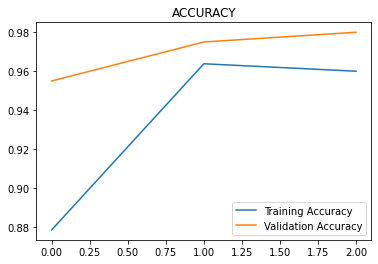

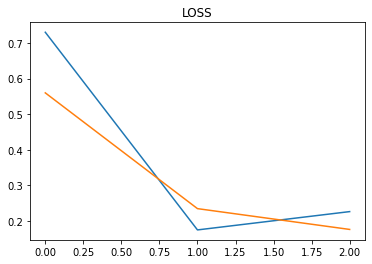

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('ACCURACY')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('LOSS')
plt.show()